In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
sns.set(style='white', context='notebook', palette='deep')

In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
train_data.shape

(42000, 785)

# Data check

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

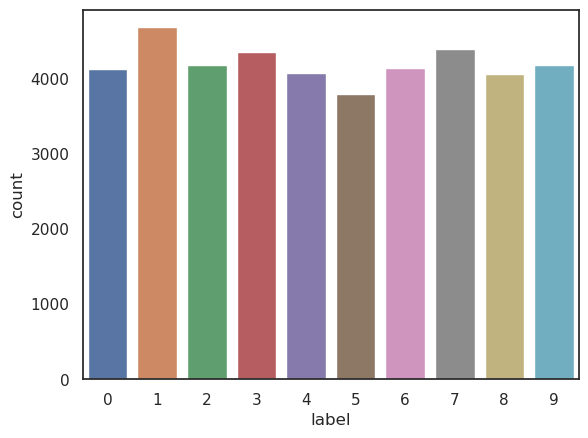

In [5]:
y_train, X_train = train_data['label'], train_data.drop(columns=['label'], axis=1)
X_test = test_data
g = sns.countplot(x=y_train)
y_train.value_counts()

In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# Normalization

In [8]:
X_train /= 255.0
X_test /= 255.0

# Reshaping to 3D

In [9]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

Label encoding

In [10]:
y_train = to_categorical(y_train, num_classes = 10)

# Splitting data

In [11]:
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=random_seed)

# Some initial data visualization

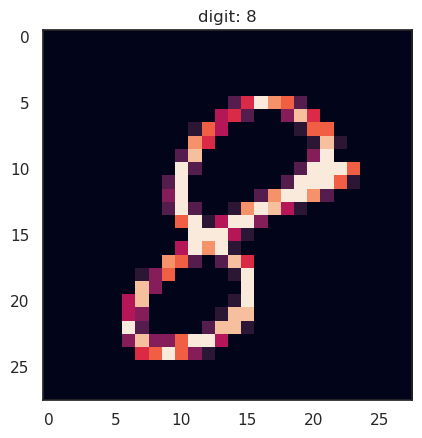

In [12]:
plt.imshow(X_train[0, :])
plt.title('digit: '+ str(y_train[0].argmax()))
plt.show()

# Model definition

In [13]:
model = Sequential(
    [
        Conv2D(32,(5,5), padding='Same', activation='relu', input_shape = (28,28,1)),
        Conv2D(32,(5,5), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.15),
        Conv2D(64,(3,3), padding='Same', activation='relu'),
        Conv2D(64,(3,3), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2)),
        Dropout(0.15),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ]
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [15]:
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=RMSprop(epsilon=1e-08, decay=0.0),
    metrics=["accuracy"],
)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
epochs = 30
batch_size = 86

# Data augmentation

In [18]:
data_gen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
data_gen.fit(X_train)

# Let's fit the model

In [19]:
history = model.fit_generator(data_gen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30


/tmp/ipykernel_20/1861706986.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_gen.flow(X_train,y_train, batch_size=batch_size),


439/439 - 178s - loss: 0.3741 - accuracy: 0.8809 - val_loss: 0.0635 - val_accuracy: 0.9802 - lr: 0.0010 - 178s/epoch - 406ms/step
Epoch 2/30
439/439 - 175s - loss: 0.1068 - accuracy: 0.9679 - val_loss: 0.0386 - val_accuracy: 0.9886 - lr: 0.0010 - 175s/epoch - 398ms/step
Epoch 3/30
439/439 - 176s - loss: 0.0768 - accuracy: 0.9772 - val_loss: 0.0526 - val_accuracy: 0.9843 - lr: 0.0010 - 176s/epoch - 402ms/step
Epoch 4/30
439/439 - 175s - loss: 0.0629 - accuracy: 0.9806 - val_loss: 0.0425 - val_accuracy: 0.9879 - lr: 0.0010 - 175s/epoch - 399ms/step
Epoch 5/30
439/439 - 175s - loss: 0.0562 - accuracy: 0.9836 - val_loss: 0.0266 - val_accuracy: 0.9929 - lr: 0.0010 - 175s/epoch - 400ms/step
Epoch 6/30
439/439 - 175s - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.0264 - val_accuracy: 0.9917 - lr: 0.0010 - 175s/epoch - 398ms/step
Epoch 7/30
439/439 - 175s - loss: 0.0490 - accuracy: 0.9859 - val_loss: 0.0274 - val_accuracy: 0.9924 - lr: 0.0010 - 175s/epoch - 399ms/step
Epoch 8/30
439/439 - 175

In [20]:
predictions = np.argmax(model.predict(X_test), axis=1)
submission = pd.DataFrame({'ImageId': range(1,len(X_test)+1) ,'Label': predictions })
submission.to_csv("simple_tf_result.csv",index=False)

875/875 [==============================] - 27s 31ms/step
